To Do: \
V2: \
- ~~Alter obstacles to be connected vertices~~
 - ~~Add capability for checking movement validity inside new obstacles~~
- Add ability to stay still?
- Alter random walk to be 1 unit in random direction
Bug fixes:
- need to make it so collision detects whole line between current and next point



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
from scipy.spatial import ConvexHull


In [2]:
class Robot:
    """
    Basic robot class that can move and keeps track of past postions
    """
    def __init__(self, start_pos):
        self.pos = start_pos
        self.path = [start_pos]

    def move(self, new_pos):
        self.pos = new_pos
        self.path.append(self.pos)

    def get_position(self):
        return self.pos

    def get_path(self):
      return self.path

class Environment:
    """
    Holds the description of the environment such as size and obstacles
    V1: obstacles are each only a point
    V2: each obstacle is a list of vertices
    """
    def __init__(self, size=(8,8)):
      self.size = size
      self.obstacles = []

    def get_size(self):
      return self.size

    def get_obstacles(self):
      return self.obstacles

    def random_obstacles(self, num_obstacles, max_vertex, max_size):
      for _ in range(num_obstacles):
        self.obstacles.append(self.generate_random_polygon(num_vertices = np.random.randint(3, max_vertex+1), size = np.random.rand()*max_size, offsetx = np.random.rand()*self.size[0], offsety = np.random.rand()*self.size[1]))

    def generate_random_polygon(self, num_vertices, size, offsetx, offsety):
      """Generates a random non-intersecting polygon with the given number of vertices.
      ToDo add random offset for both x and y
      """
      # Generate random points
      points = np.random.rand(num_vertices, 2)
      #print(points)
      #print(size)
      points = np.multiply(points, size)
      #print(points)
      #print(offsetx)
      #print(offsety)
      points[:, 0] += offsetx
      points[:, 1] += offsety
      #print(points)
      # Compute the convex hull
      hull = ConvexHull(points)
      # Extract the vertices of the convex hull
      polygon_vertices = points[hull.vertices]
      #print(polygon_vertices)
      return polygon_vertices

    def set_obstacles(self, obstacles):
      self.obstacles = obstacles


class Swarm:
    """
    Swarm class that holds the robots and environment
    contains methods to globally move the swarm around
    """
    def __init__(self, num_actors, environment, init):
      self.environment = environment
      self.num_actors = num_actors
      self.actors = []
      next_pos = 0
      if init == 'close':
        self.close_init()
      elif init == 'random':
        self.random_init()

    def close_init(self):
      next_pos = 0
      while len(self.actors) < self.num_actors:
        if self.is_valid_move((0,next_pos)):
          self.actors.append(Robot((0,next_pos)))
        else:
          next_pos += 1

    def random_init(self):
      while len(self.actors) < self.num_actors:
        pos = (np.random.randint(0, self.environment.get_size()[0]), np.random.randint(0, self.environment.get_size()[1]))
        if self.is_valid_move(pos):
          self.actors.append(Robot(pos))

    def is_valid_move(self, position):
      size = self.environment.get_size()
      if self.obstacle_collision(position) or position[0] < 0 or position[1] < 0 or position[0] > size[0] or position[1] > size[1]:
        return False
      for bot in self.actors:
        if bot.get_position() == position:
          return False
      return True

    def obstacle_collision(self, position):
      """
      Determines whether a point is inside an obstacle.
      """
      x, y = position
      inside = False

      for obstacle in self.environment.get_obstacles():
        for i in range(len(obstacle)):
          x1, y1 = obstacle[i]
          x2, y2 = obstacle[(i+1) % len(obstacle)]
          if (y > min(y1, y2)) and (y <= max(y1, y2)) and (x <= max(x1, x2)):
            if y1 != y2:
              xinters = (y - y1) * (x2 - x1) / (y2 - y1) + x1
              if xinters > x:
                inside = not inside
      return inside


    def random_walk(self, steps=100):
      for _ in range(steps):
        for bot in self.actors:
          current_pos = bot.get_position()
          new_pos = (current_pos[0] + np.random.randint(-1, 2), current_pos[1]+(np.random.randint(-1, 2)))
          #print(current_pos)
          #print(new_pos)
          #print("\n")
          if self.is_valid_move(new_pos):
            bot.move(new_pos)

    def draw_map(self):
      fig, ax = plt.subplots()
      ax.set_xlim(-0.5, self.environment.get_size()[1]-0.5)
      ax.set_ylim(-0.5, self.environment.get_size()[0]-0.5)
      ax.set_xticks(np.arange(-0.5, self.environment.get_size()[1], 1), minor=True)
      ax.set_yticks(np.arange(-0.5, self.environment.get_size()[0], 1), minor=True)
      for obstacle in self.environment.get_obstacles():
        x, y = zip(*obstacle)
        plt.fill(x, y, color='blue', alpha=0.5)
      return fig, ax

    def plot(self):
      fig, ax = self.draw_map()
      for bot in self.actors:
        path = bot.get_path()
        x_pos = list(zip(*path))[0]
        y_pos = list(zip(*path))[1]
        #print(path)
        #print(x_pos)
        #print(y_pos)
        ax.plot(x_pos, y_pos)



    def animate(self, interval=200, filename='animation.gif'):
      """
      Animates the plotting of the swarm.
      """
      fig, ax = self.draw_map()
      lines = []
      # Create lines for each data set
      for bot in self.actors:
          line, = ax.plot([], [], lw=2)
          lines.append(line)

      # Animation function
      def init():
          for line in lines:
              line.set_data([], [])
          return lines

      def animate_func(i):
          for line, bot in zip(lines, self.actors):
              path = bot.get_path()
              x_pos = list(zip(*path))[0]
              y_pos = list(zip(*path))[1]
              line.set_data(x_pos[:i+1], y_pos[:i+1])
          return lines

      # Create the animation
      anim = animation.FuncAnimation(fig, animate_func, init_func=init,
                                      frames=len(self.actors[0].get_path()), interval=interval, blit=True)

      # Save the animation
      anim.save(filename, writer='ffmpeg')
      anim
      plt.close(fig)




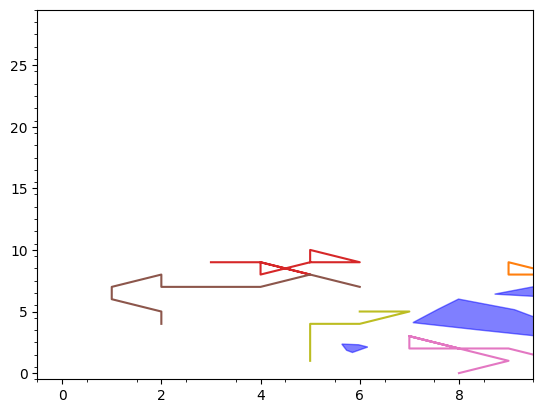

In [12]:
width = 30
height = 10
num_actors = 10
num_obstacles = 10
max_vertices = 7
max_size = 10
rand_env = Environment((width, height))
rand_env.random_obstacles(num_obstacles, max_vertices, max_size)

test_swarm = Swarm(num_actors, rand_env, init = 'random')
test_swarm.random_walk(10)
test_swarm.plot()
test_swarm.animate()

In [ ]:
import numpy as np
from collections import deque
import heapq

# Chessboard size and knight moves
CHESSBOARD_SIZE = 100
KNIGHT_MOVES = [(2, 1), (2, -1), (-2, 1), (-2, -1),
                (1, 2), (1, -2), (-1, 2), (-1, -2)]

def get_neighbors(position, obstacles):
    """Generate all valid knight moves from the current position based on edge definition."""
    x, y = position
    neighbors = []
    for dx, dy in KNIGHT_MOVES:
        nx, ny = x + dx, y + dy
        if is_valid_move(nx, ny, obstacles):
          if (abs(x - nx) == 2 and abs(y - ny) == 1) or (abs(x - nx) == 1 and abs(y - ny) == 2):
            neighbors.append((nx, ny))

    return neighbors

def is_valid_move(nx, ny, obstacles):
      if (nx, ny) not in obstacles :
        if nx >= 0 and nx < CHESSBOARD_SIZE and ny >= 0 and ny < CHESSBOARD_SIZE:
          return True
      return False

def bfs_knight(start, goal, obstacles=set()):
    """Breadth-First Search (BFS) for finding the shortest path for the knight."""
    queue = deque([(start, [])])
    visited = set([start])

    while queue:
        current, path = queue.popleft()
        path = path + [current]

        if current == goal:
            return path

        for neighbor in get_neighbors(current, obstacles):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append((neighbor, path))

    return None

def dfs_knight(start, goal, obstacles=set()):
    """Depth-First Search (DFS) for finding a path for the knight."""
    stack = [(start, [])]
    visited = set([start])

    while stack:
        current, path = stack.pop()
        path = path + [current]

        if current == goal:
            return path

        for neighbor in get_neighbors(current, obstacles):
            if neighbor not in visited:
                visited.add(neighbor)
                stack.append((neighbor, path))

    return None

def euclidean_distance(a, b):
    """Calculate the Euclidean distance (L2 norm) between two points."""
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def check_mate_heuristic(current, goal):
    """Calculate the check-mate heuristic between the current position and the goal."""
    # Check-mate positions around the goal state
    check_mate_positions = [
        (goal[0] + 2, goal[1] + 1), (goal[0] + 2, goal[1] - 1),
        (goal[0] - 2, goal[1] + 1), (goal[0] - 2, goal[1] - 1),
        (goal[0] + 1, goal[1] + 2), (goal[0] + 1, goal[1] - 2),
        (goal[0] - 1, goal[1] + 2), (goal[0] - 1, goal[1] - 2)
    ]

    # Calculate minimum distance to a check-mate position
    return min(euclidean_distance(current, pos) for pos in check_mate_positions)

def a_star_knight_check_mate(start, goal, obstacles=set()):
    """A* Search Algorithm using the check-mate heuristic for the knight."""
    priority_queue = [(0, start, [])]
    visited = set()

    while priority_queue:
        cost, current, path = heapq.heappop(priority_queue)
        path = path + [current]

        if current == goal:
            return path

        if current in visited:
            continue
        visited.add(current)

        for neighbor in get_neighbors(current, obstacles):
            if neighbor not in visited:
                heuristic = check_mate_heuristic(neighbor, goal)
                total_cost = cost + 1 + heuristic
                heapq.heappush(priority_queue, (total_cost, neighbor, path))

    return None

def plot_grid_and_line(grid_shape, initial_position, goal, movements):
  policy_grid = np.full(grid_shape, '')
  fig, ax = plt.subplots()
  fig.set_figheight(8)
  fig.set_figwidth(8)
  ax.set_xlim(-0.5, grid_shape[1]-0.5)
  ax.set_ylim(-0.5, grid_shape[0]-0.5)
  ax.set_xticks(np.arange(-0.5, grid_shape[1], 1), minor=True)
  ax.set_yticks(np.arange(-0.5, grid_shape[0], 1), minor=True)
  ax.grid(which = 'minor', color = 'k', linestyle = '-', linewidth = .5)
  ax.text(goal[1], goal[0], "X", ha = 'center', va = 'center', color = "red", fontsize = 16)
  ax.text(initial_position[1], initial_position[0], "0", ha = 'center', va = 'center', color = "black", fontsize = 16)
  ax.set_title("start pos: " + str(start_pos) + " goal pos: " + str(goal_pos))
  for i in range(len(movements)-1) :
    ax.plot([movements[i][1], movements[i+1][1]], [movements[i][0], movements[i+1][0]])


# Example usage for Week 4:
if __name__ == "__main__":
    start_pos = (0, 0)
    goal_pos = (7, 7)
    obstacles = {(7,6), (4, 4)}

    #print("BFS Path:", bfs_knight(start_pos, goal_pos, obstacles))
    #print("DFS Path:", dfs_knight(start_pos, goal_pos, obstacles))
    #print("A* Path (Euclidean):", a_star_knight_check_mate(start_pos, goal_pos, obstacles))

#Some boiler plate code was generated from a code generation tool.